# Linear Regression (Chapter 3 ISL book)

- [Load Datasets](#Load-Datasets)
- [Loss Functions](#Loss-Functions)
- [Reproducing ISL](#ISL)
    - [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
    - [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
    - [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)
        - [3.3.1 Collinearity](#3.3.1-Collinearity)
        - [3.3.2 Qualitative/Categorical Variables](#3.3.2-Qualitative/Categorical-Variables)
        - [3.3.3 Interactions](3.3.3 Interactions)
        - [3.3.4 Non-linear relationships](#3.3.4-Non-linear-relationships)
        - [3.3.5 Outliers](#3.3.5-Outliers)
    - [3.4 Model Selection](#3.4-Model-Selection)

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import scipy

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Datasets
Datasets available on http://faculty.marshall.usc.edu/gareth-james/ISL/

In [2]:
advertising = pd.read_csv('../data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [3]:
credit = pd.read_csv('../data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [4]:
auto = pd.read_csv('../data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 391
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null int64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
Manufacturer    392 non-null object
dtypes: float64(3), int64(5), object(2)
memory usage: 33.7+ KB


## Loss Functions

Let us take a quick look at the distribution of weights and compute summary statistics

mean: 2977.58
median: 2803.5
mode: ModeResult(mode=array([2200.]), count=array([28]))


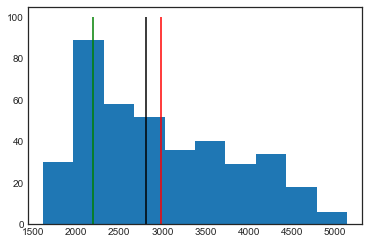

In [7]:
tmp=plt.hist(auto["weight"])
# LE = location estimate
LE1 = np.round(np.mean(auto["weight"]),2)
LE2 = np.round(np.median(auto["weight"]),2)
LE3 = scipy.stats.mode(np.round(auto["weight"]/100)*100)
plt.vlines(LE1,0,100, colors="red")
plt.vlines(LE2,0,100, colors="black")
plt.vlines(LE3[0],0,100, colors="green")

print("mean:",  LE1)
print("median:",  LE2)
print("mode:",  LE3)

We can see a marked difference between the mean and the median (why again?). 
That brings up the general question, how to choose from the various "location measures" of a distribution, such as the mean, median, trimmed mean, geometric mean, harmonic mean, ...


Can we define an objective optimality measure which would clearly favor one metric over another ? 
Welcome to the concept of a **loss function**.
We all feel intuitively that the orange line (at 3615 lb) is in some sense inferior to the red and green numbers as a location measure. Why, because the distance from the data to orange is (on the average) larger than the distance to red and green. Let us call that average distance a "loss" and assume that we want to **minimize loss**.

It turns out that there is not just one but various ways to define this distance/loss function ("LE" = location estimate):

1. $$ L_0 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^0}$$
2. $$ L_1 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^1}$$
3. $$ L_2 = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|^2}$$
4. $$ L_p = (1/n) \cdot \sum_{i=1}^n{|x_i - LE|}^p$$

**Your Tasks:**

* Identify the one that is minimized by the average.
* Identify the one that is minimized by the median.
* Which measure is minimized by $L_0$ ? 
* Verify your assertions emprically !

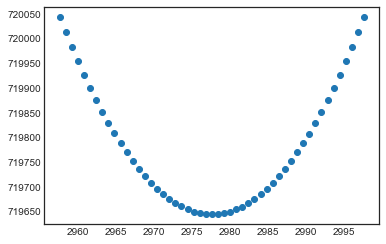

In [95]:
def L2(x,LE):
    return(np.mean((x - LE) * (x - LE)))
    
xg = np.linspace(LE1-20, LE1 +20, 51)
MSE = np.empty_like(xg) 
for i, a in enumerate(xg):
    MSE[i]= L2(auto["weight"], a)

tmp=plt.scatter(xg,MSE)

## 3.1 Simple Linear Regression

Loss Function = squared residuals !

**Least Squares** equals minimizing $RSS = \sum_{i=1}^n{u_i^2}$

* Remind yourself of the definition of the slope of a straight line

<div>
<img src="figures/SlopeIllustration.png" width="400"/>
</div>

$$
\beta_1 = \frac{\Delta y}{\Delta x} =  \frac{y_2-y_1}{x_2-x_1}
$$

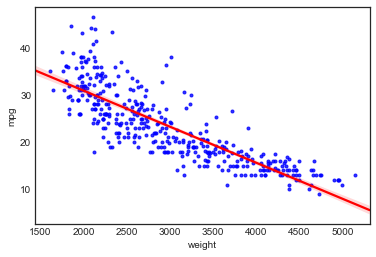

In [96]:
tmp=sns.regplot(auto["weight"], auto["mpg"], order=1, ci=95, 
                scatter_kws={'color':'b', 's':9}, line_kws={'color':'r'})

sklearn does not seem to offer even standard errors !
(https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error)

Module **statsmodels** gives output closer in line with other statistical software:

In [97]:
est = smf.ols('mpg ~ weight', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,46.2165,0.799,57.867,0.000,44.646,47.787
weight,-0.0076,0.000,-29.645,0.000,-0.008,-0.007


In [25]:
est = smf.ols('mpg ~ C(origin) + weight', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,43.7322,1.113,39.277,0.000,41.543,45.921
C(origin)[T.2],0.9709,0.659,1.474,0.141,-0.324,2.266
C(origin)[T.3],2.3271,0.665,3.501,0.001,1.020,3.634
weight,-0.0070,0.000,-21.956,0.000,-0.008,-0.006


In [11]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


In [10]:
est = smf.ols('mpg ~ horsepower', auto).fit()
est.summary(alpha=0.01)#.tables[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 10 Nov 2020   Prob (F-statistic):           7.03e-81
Time:                        12:49:38   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.005      0.995]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.079      41.793
horsepower    -0.1578      0.006    -24.489      0.000      -0.175      -0.141
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
from scipy.stats import t
tC =t.ppf(0.995,390)#2.588
-0.1578 - tC*0.006
#-0.1578 + tC*0.006
est.conf_int(alpha = 0.01)

,0,1
Intercept,38.078620,41.793102
horsepower,-0.174529,-0.141161


--------------------------------------------------------
# ISL

In the following sections we are mainly reproducing figures and results from the ISL book.

### Figure 3.1 - Least squares fit

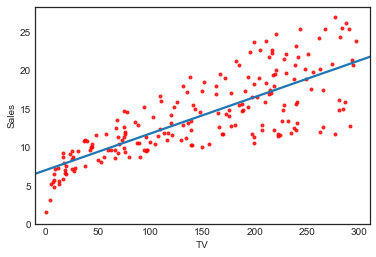

In [11]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [73]:
np.corrcoef(advertising.TV, advertising.Sales)

array([[1.        , 0.78222442],
       [0.78222442, 1.        ]])

In [16]:
#what data structures does the fit function want?
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
y = np.dot(X, np.array([1, 2])) + 3
reg = skl_lm.LinearRegression().fit(X, y)
reg.coef_
type(advertising.Sales)

pandas.core.series.Series

In [70]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

#X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
X=advertising.TV.values.reshape(-1,1)
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)

y = advertising.Sales.values

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [76]:
regr.

<bound method BaseEstimator.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)>

### Tasks

1. Compute the residuals, their sum and RSS (are they different for non-centered X?)
2. Compute $R^2$ and compare with the correlation coefficient $\rho$.
3. Interpret the meaning of the slope $\hat{\beta_1}$.
4. Obtain $SE(\hat{\beta_1})$ and a 95% confidence interval for the slope.
5. Discuss how one could use resampling to obtain non-parametric confidence intervals
6. (homework) Test whether the true slope could be 0.

## Least Squares

Is RSS really minimized ?


In [19]:
# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

In [71]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = np.sum((xx[i,j] + yy[i,j]*X - y.reshape(-1,1))**2)/1000
 #   Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

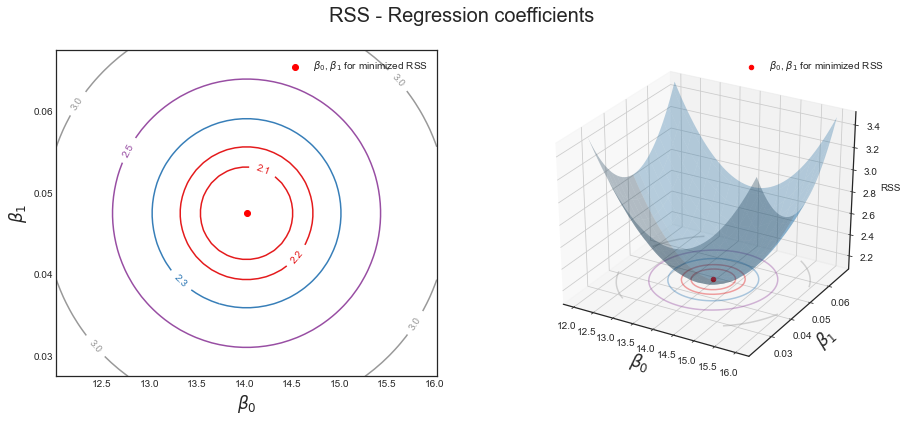

In [72]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [52]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [24]:
# RSS with regression coefficients
((advertising.Sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()/1000

2.1025305831313514

### Table 3.1 & 3.2 - Scikit-learn

![p.68](figures/ISLR-Table3.1.png)

![p.69](figures/ISLR-Table3.2.png)

In [25]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127693
[0.04753664]


In [26]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071

## 3.2 Multiple Linear Regression

How can we extend our analysis of the advertising data in order
to accommodate these two additional predictors?
One option is to run three separate simple linear regressions, each of
which uses a different advertising medium as a predictor.

However, the approach of fitting a separate simple linear regressionmodel
for each predictor is not entirely satisfactory. First of all, it is unclear how to
make a single prediction of sales given levels of the three advertising media
budgets, since each of the budgets is associated with a separate regression
equation. Second, each of the three regression equations ignores the other
two media in forming estimates for the regression coefficients. We will see
shortly that if the media budgets are correlated with each other in the 200
markets that constitute our data set, then this can lead to very misleading
estimates of the individual media effects on sales.
Instead of fitting a separate simple linear regression model for each predictor,
a better approach is to extend the simple linear regression model
(3.5) so that it can directly accommodate multiple predictors. We can do
this by giving each predictor a separate slope coefficient in a single model.
In general, suppose that we have p distinct predictors. Then the multiple
linear regression model takes the form
$$
Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon 
$$

We interpret $\beta_j$ as the average effect on Y of a one unit increase in $X_j$, **holding all other predictors fixed**.


### Table 3.3 - Statsmodels

In [27]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [28]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


In [29]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


### Table 3.4 & 3.6 - Statsmodels

We interpret these results as follows: for a given
amount of TV and newspaper advertising, spending an additional $1,000
on radio advertising leads to an increase in sales by approximately 189
units. Comparing these coefficient estimates to those displayed in Tables 3.1
and 3.3, we notice that the multiple regression coefficient estimates for
TV and radio are pretty similar to the simple linear regression coefficient
estimates. However, while the newspaper regression coefficient estimate in
Table 3.3 was significantly non-zero, the coefficient estimate for newspaper
in the multiple regression model is close to zero, and the corresponding
p-value is no longer significant, with a value around 0.86. This illustrates that the simple and multiple regression coefficients can be quite different.
This difference stems from the fact that in the simple regression case, the
slope term represents the average effect of a 1,000 increase in newspaper
advertising, ignoring other predictors such as TV and radio. In contrast, in
the multiple regression setting, the coefficient for newspaper represents the
average effect of increasing newspaper spending by 1,000 **while holding TV and radio fixed**.

In [30]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 02 Nov 2020   Prob (F-statistic):           1.58e-96
Time:                        20:53:28   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

Does it make sense for the multiple regression to suggest no relationship
between sales and newspaper while the simple linear regression implies the
opposite? In fact it does. Consider the correlation matrix for the three
predictor variables and response variable, displayed in Table 3.5. Notice
that the correlation between radio and newspaper is 0.35. This reveals a
tendency to spend more on newspaper advertising in markets where more
is spent on radio advertising. Now suppose that the multiple regression is
correct and newspaper advertising has no direct impact on sales, but radio
advertising does increase sales. Then in markets where we spend more
on radio our sales will tend to be higher, and as our correlation matrix
shows, we also tend to spend more on newspaper advertising in those same
markets. Hence, in a simple linear regression which only examines sales
versus newspaper, we will observe that higher values of newspaper tend to be
associated with higher values of sales, even though newspaper advertising
does not actually affect sales. So newspaper sales are a surrogate for radio
advertising; newspaper gets “credit” for the effect of radio on sales.
This slightly counterintuitive result is very common in many real life
situations. Consider an absurd example to illustrate the point. Running
a regression of shark attacks versus ice cream sales for data collected at
a given beach community over a period of time would show a positive
relationship, similar to that seen between sales and newspaper. Of course
no one (yet) has suggested that ice creams should be banned at beaches
to reduce shark attacks. In reality, higher temperatures cause more people
to visit the beach, which in turn results in more ice cream sales and more
shark attacks. A multiple regression of attacks versus ice cream sales and
temperature reveals that, as intuition implies, the former predictor is no
longer significant after adjusting for temperature.

In [31]:
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


### Figure 3.5 - Multiple Linear Regression

![p.81](figures/ISLR-Fig3.5.png)

In [32]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].as_matrix()
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [34]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  del sys.path[0]


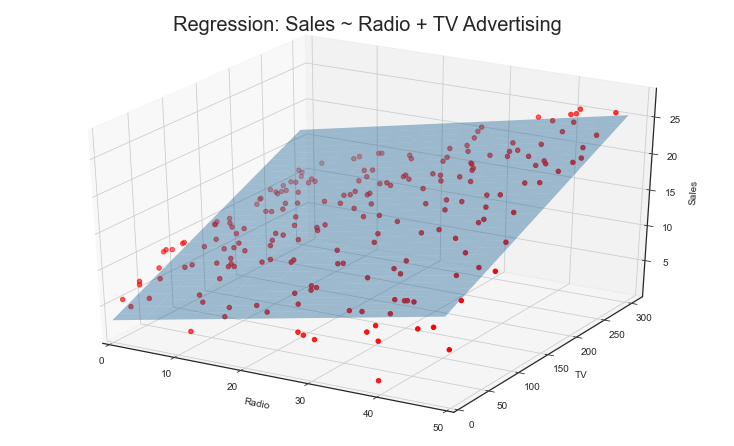

In [35]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

-----------------------------------------------------------
### 3.3.1 Collinearity

#### "Exact Collinearity" 


##### Tasks

1. You try to impress your investors with the number of advertising channels that you have investigated. So you make a copy of the TV column, call it *facebook* and refit the linear multiple regression.

2. **Multi-Collinearity**: You have learned from your foolish mistakes and are more ambitiously creating *fake data*: You create a new column *instagram* by adding TV and Radio and subtracting 3 times Newspaper. Now, refit the linear multiple regression.



In [11]:
advertising["facebook"] = advertising.TV
#advertising.info()

est = smf.ols('Sales ~ TV + Radio + Newspaper + facebook', advertising).fit()
es = est.summary()
es.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0229,0.001,32.809,0.000,0.022,0.024
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011
facebook,0.0229,0.001,32.809,0.000,0.022,0.024


Multicollinearity is treated VERY differently in statsmodels than in R as discussed in this
[post on medium](https://medium.com/@docintangible/multicollinearity-in-pythons-statsmodels-ols-vs-r-s-lm-6fc9a994154c) as well on [stackoverflow](https://stackoverflow.com/questions/25676145/capturing-high-multi-collinearity-in-statsmodels).
Worthwhile to inspect the [condition number](https://en.wikipedia.org/wiki/Condition_number#Matrices):

In [13]:
es.tables[2]

Omnibus:,60.414,Durbin-Watson:,2.084
Prob(Omnibus):,0.000,Jarque-Bera (JB):,151.241
Skew:,-1.327,Prob(JB):,1.44e-33
Kurtosis:,6.332,Cond. No.,2.61e+16


In [14]:
advertising["instagram"] = advertising.TV +advertising.Radio - 3*advertising.Newspaper
#advertising.info()

est = smf.ols('Sales ~ TV + Radio + Newspaper + instagram', advertising).fit()
es = est.summary()
es.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0260,0.002,11.660,0.000,0.022,0.030
Radio,0.1687,0.008,22.469,0.000,0.154,0.184
Newspaper,0.0583,0.002,27.223,0.000,0.054,0.063
instagram,0.0198,0.002,10.679,0.000,0.016,0.023


In [15]:
es.tables[2]

Omnibus:,60.414,Durbin-Watson:,2.084
Prob(Omnibus):,0.000,Jarque-Bera (JB):,151.241
Skew:,-1.327,Prob(JB):,1.44e-33
Kurtosis:,6.332,Cond. No.,2.32e+16



#### Figure 3.6

What about non-exact collinearities?

In [ ]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

#### "High Collinearity" 

*Collinearity* refers to the situation in which two or more predictor variables are closely related to one another. The concept of collinearity is illustrated in Figure 3.14 using the Credit data set. In the left-hand panel of Figure 3.14, the two predictors limit and age appear to have no obvious relationship.
In contrast, in the right-hand panel of Figure 3.14, the predictors
limit and rating are very highly correlated with each other, and we say
that they are **collinear**. The presence of collinearity can pose problems in the regression context, since it can be difficult to separate out the individual effects of collinear variables on the response. In other words, since limit and rating tend to increase or decrease together, it can be difficult to determine how each one separately is associated with the response, *balance*.

#### Figure 3.14

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15
Figure 3.15 illustrates some of the difficulties that can result from collinearity.
The left-hand panel of Figure 3.15 is a contour plot of the RSS (3.22)
associated with different possible coefficient estimates for the regression
of balance on limit and age. Each ellipse represents a set of coefficients
that correspond to the same RSS, with ellipses nearest to the center taking
on the lowest values of RSS. The  dots and associated dashed lines represent the coefficient estimates that result in the smallest possible
RSS—in other words, these are the least squares estimates. The axes for
limit and age have been scaled so that the plot includes possible coefficient
estimates that are up to four standard errors on either side of the
least squares estimates. Thus the plot includes all plausible values for the
coefficients. For example, we see that the true limit coefficient is almost
certainly somewhere between 0.15 and 0.20.
In contrast, the right-hand panel of Figure 3.15 displays contour plots
of the RSS associated with possible coefficient estimates for the regression
of balance onto limit and rating, which we know to be highly collinear.
Now the contours run along a narrow valley; there is a broad range of
values for the coefficient estimates that result in equal values for RSS.
Hence a small change in the data could cause the pair of coefficient values
that yield the smallest RSS—that is, the least squares estimates—to move
anywhere along this valley. This results in a great deal of uncertainty in the
coefficient estimates. Notice that the scale for the limit coefficient now runs
from roughly −0.2 to 0.2; this is an eight-fold increase over the plausible
range of the limit coefficient in the regression with age.

In [37]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].as_matrix()
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].as_matrix()
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

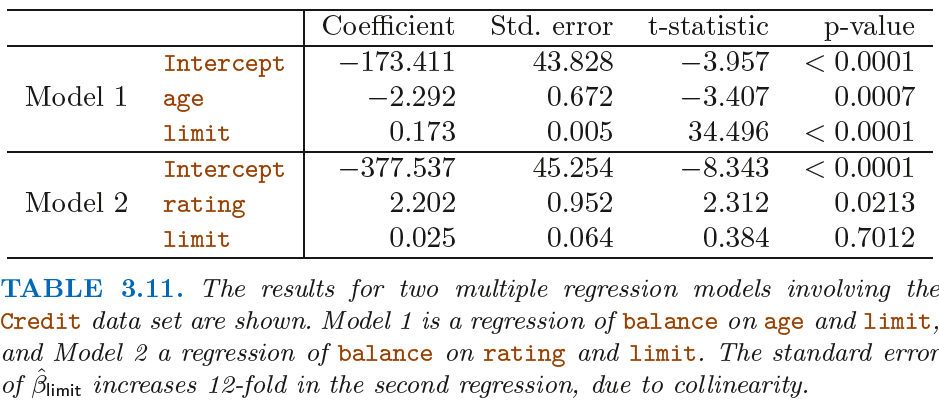

Table 3.11 compares the coefficient estimates obtained from two separate multiple regression models. The first is a regression of balance on age and limit, and the second is a regression of balance on rating and limit. In the first regression, both age and limit are highly significant with very small pvalues.
In the second, the collinearity between limit and rating has caused
the standard error for the limit coefficient estimate to increase by a factor of 12 and the p-value to increase to 0.701. In other words, the importance of the limit variable has been masked due to the presence of collinearity.
To avoid such a situation, it is desirable to identify and address potential collinearity problems while fitting the model.

-------------------------------------------------------
### 3.3.2 Qualitative/Categorical Variables

- Dummy Coding
- Interpretation of coefficients

#####  Table 3.7

![p.84](figures/ISLR-Table3.7.png)

In [18]:
est = smf.ols('Balance ~ Gender ', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


### Table 3.8

In [14]:
np.unique(credit["Ethnicity"])
pd.groupby(credit, "Ethnicity")["Balance"].mean()

C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


Ethnicity
African American    531.000000
Asian               512.313725
Caucasian           518.497487
Name: Balance, dtype: float64

In [54]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### 3.3.3 Interactions

##### Table 3.9

In [55]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


#### Figure 3.7 - Interaction between qualitative and quantitative variables

In [41]:
credit["Income2"] = credit["Income"] + scipy.stats.norm.rvs(400)


In [42]:
est1 = smf.ols('Balance ~ Income + Income2 + C(Student)', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*C(Student)', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
est1.summary().tables[1]

Regression 1 - without interaction term


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0123,0.002,-7.146,0.000,-0.016,-0.009
C(Student)[T.Yes],382.6705,65.311,5.859,0.000,254.272,511.069
Income,5.4564,0.621,8.781,0.000,4.235,6.678
Income2,0.5280,0.081,6.506,0.000,0.368,0.688


In [29]:
np.mean(credit["Income"])

45.218885000000036

In [30]:
est2 = smf.ols('Balance ~ Income + Income*C(Ethnicity)*C(Student)', credit).fit()
est2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,145.1346,64.922,2.236,0.026,17.492,272.777
C(Ethnicity)[T.Asian],-15.5992,94.976,-0.164,0.870,-202.332,171.133
C(Ethnicity)[T.Caucasian],122.8200,80.930,1.518,0.130,-36.297,281.937
C(Student)[T.Yes],427.5858,246.321,1.736,0.083,-56.706,911.877
C(Ethnicity)[T.Asian]:C(Student)[T.Yes],281.3665,297.683,0.945,0.345,-303.906,866.639
C(Ethnicity)[T.Caucasian]:C(Student)[T.Yes],-109.7842,309.373,-0.355,0.723,-718.041,498.473
Income,7.1950,1.069,6.728,0.000,5.093,9.298
Income:C(Ethnicity)[T.Asian],0.0963,1.667,0.058,0.954,-3.181,3.374
Income:C(Ethnicity)[T.Caucasian],-2.0995,1.371,-1.531,0.127,-4.796,0.597
Income:C(Student)[T.Yes],-0.0693,3.716,-0.019,0.985,-7.375,7.236


In [26]:
print('\nRegression 2 - with interaction term')
est2.summary().tables[1]


Regression 2 - with interaction term


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,200.6232,33.698,5.953,0.000,134.373,266.873
C(Student)[T.Yes],476.6758,104.351,4.568,0.000,271.524,681.827
Income,6.2182,0.592,10.502,0.000,5.054,7.382
Income:C(Student)[T.Yes],-1.9992,1.731,-1.155,0.249,-5.403,1.404


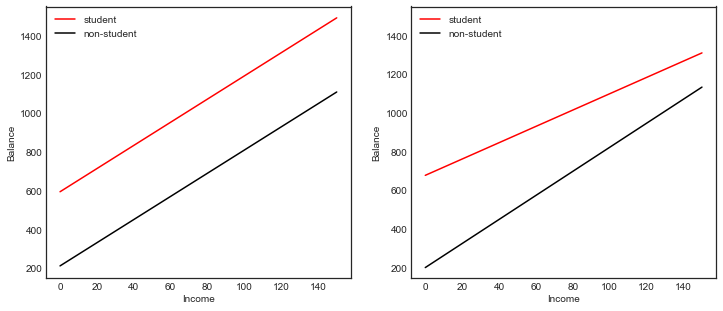

In [15]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### 3.3.4 Non-linear relationships
#### Figure 3.8 

In [ ]:
sns.regplot('weight', 'mpg', data=auto,fit_reg=True, order=2)

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [58]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,Manufacturer,pred1,resid1,horsepower2
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet,19.416046,-1.416046,16900
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,buick,13.891480,1.108520,27225
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,plymouth,16.259151,1.740849,22500


In [59]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### 3.3.5 Outliers

##### Figure 3.9

In [60]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


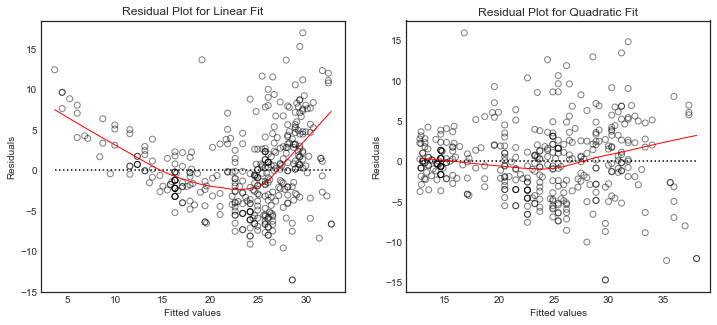

In [61]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

## 3.4 Model Selection

In [77]:
np.any([True, False, False])

True

In [78]:
np.any([False, False, False])

False